In [ ]:
# this file is to prepare density map of gt using global which takes around few minutes

In [ ]:
# file ni pakai global so make sure pakai gaussian mana dulu !!!

In [1]:
!pip install opencv-python-headless torchvision h5py scipy numpy matplotlib image scikit-image

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import glob
import json
import numpy as np
import scipy
import scipy.io as io
import h5py
from scipy.ndimage import gaussian_filter
import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import torch
import importlib
import model
importlib.reload(model)
from model import CSRNet
from image import *

%matplotlib inline

In [3]:
# checking
print(cv2.__version__)
print(torch.__version__)
print(torch.rand(2, 3))
print(dir(model))

4.11.0
2.7.0+cu126
tensor([[0.0421, 0.7087, 0.1781],
        [0.5847, 0.5269, 0.8353]])
['CSRNet', 'VGG16_Weights', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'load_net', 'make_layers', 'models', 'nn', 'save_net', 'torch', 'vgg16']


In [4]:
!pip install kagglehub

import kagglehub
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1


In [5]:
root = '/home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/'

In [6]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')

path_setA = [part_A_train,part_A_test]

In [7]:
#loop all dataset

import re
def sort_by_number(path):
    filename = os.path.basename(path)
    number = int(re.findall(r'\d+', filename)[0])
    return number


img_paths_A_train = sorted(glob.glob(os.path.join(part_A_train, '*.jpg')), key=sort_by_number)
img_paths_A_test  = sorted(glob.glob(os.path.join(part_A_test, '*.jpg')), key=sort_by_number)
img_paths_A = img_paths_A_train + img_paths_A_test
print(f"{len(img_paths_A)} images in Part A")

print(f"Total images: {len(img_paths_A)}")

482 images in Part A
Total images: 482


In [8]:
#lets start! we will use global_gaussian

In [11]:
# GLobal Gaussian: using a single global Gaussian blur

# finds an avg dist between all heads using KDTree
# uses that to compute one global σ
# applies that σ over the whole image

def global_gaussian(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32) # initiliazing by creating density map of same shape with zero

    gt_count = np.count_nonzero(gt)#count #head annotations in the img
    if gt_count == 0: #if none, return empty density
        return density

    # extract coordinate of all head points in the img
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    #this return (y_indices, x_indices) of where gt==1
    #so zip(..[1])..[0]) creates (x,y) pairs


    for x, y in pts:
        density[y, x] = 1. # mark each head point in new density map w a value of 1
    print('generate density...')

    #if there is more than one head:
    #   build a KDTree ONCE for fast nearest-neighbour
    #   for each headpoint, query its 3 neighbours (exc itself) at ONCE
    #   get avg dist of those 3 neighbours
    #   take avg of all dist and scale by 0.1-> our single sigma

    # no loop

    if gt_count > 1:
        leafsize = 2048
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)#default metric used is Euclidean dist
        distances, locations = tree.query(pts, k=4) # "for each head point in pts, give its 3 neighbours"
        sigma = np.mean(distances[:, 1:4]) * 0.3 #skip the first column of distance to itself
    else:
        sigma = np.average(np.array(gt.shape))/4. #if there is only one head, use a fixed σ

    # apply one global Gaussian blur using the computed σ
    # this spreads the 1s of head locations into smooth blobs based on spacing
    density = scipy.ndimage.gaussian_filter(density, sigma, mode='constant')

    print('done.')
    return density

#very fast since only 1 blur total
#in dense crowd, avg dist betw heads is small so computed sigma is small
# sharp,tight blur

In [12]:


total = len(img_paths_A)
for idx, img_path in enumerate(img_paths_A):
    print(f"[A {idx+1}/{total}] Processing: {img_path}")

    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img = plt.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = global_gaussian(k)

    h5_path_A = img_path.replace('.jpg','.h5').replace('images','generated-h5')
    os.makedirs(os.path.dirname(h5_path_A), exist_ok=True)
    
   # if os.path.exists(h5_path):
   #     os.remove(h5_path)
   #     print(f"Deleted existing file: {h5_path}")
        
    with h5py.File(h5_path_A, 'w') as hf:
        hf['density'] = k

[A 1/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
[A 2/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_2.jpg
(713, 1024)
generate density...
done.
[A 3/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_3.jpg
(664, 1000)
generate density...
done.
[A 4/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_4.jpg
(746, 1024)
generate density...
done.
[A 5/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_5.jpg
(683, 1024)
generate density...
done.
[A 6/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_

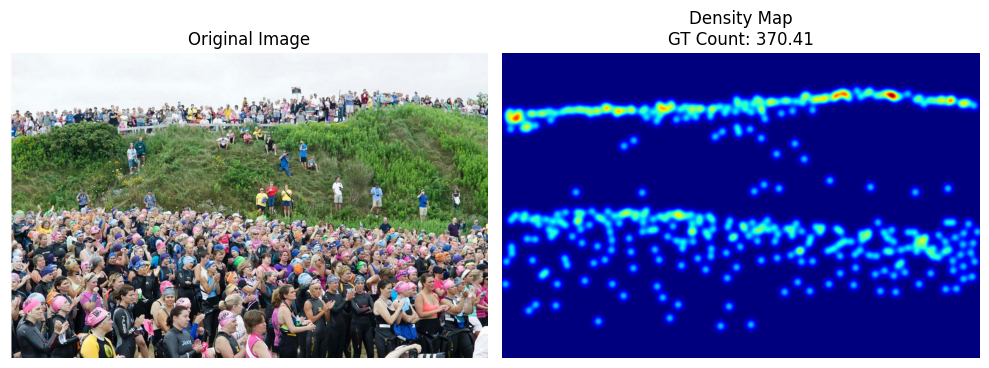

In [13]:
#checking one image
img_test = img_paths_A[99]

imgg= cv2.imread(img_test)
imgg = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)

h5_path_test = img_test.replace('.jpg','.h5').replace('images','generated-h5')
with h5py.File(h5_path_test, 'r') as hf:
    density_map_test = np.asarray(hf['density'])


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(imgg)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2) 
plt.imshow(density_map_test, cmap=CM.jet)
plt.axis('off')
plt.title(f'Density Map\nGT Count: {density_map_test.sum():.2f}')
plt.tight_layout()
plt.show()

In [14]:
img_test = img_paths_A[99]
mat_test = img_test.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_')

matt_test = io.loadmat(mat_test)
gt_test = matt_test["image_info"][0, 0][0, 0][0]

actual_count = len(gt_test)
print(f"Actual number of people in the image: {actual_count}")

Actual number of people in the image: 371


In [ ]:
#check if they all got .h5 files

In [15]:
missing_h5 = []

for img_path in img_paths_A:
    #get expected .h5 path
    h5_path = img_path.replace('.jpg', '.h5').replace('images', 'generated-h5')
    
    if not os.path.exists(h5_path):
        missing_h5.append(h5_path)

if missing_h5:
    print(f"Missing {len(missing_h5)} .h5 files:")
    for path in missing_h5[:10]:  # show only first 10
        print("  -", path)
else:
    print("All .h5 files are present for every image.")

All .h5 files are present for every image.


In [ ]:
#creating json files

In [16]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
from sklearn.model_selection import train_test_split

subset_img_paths = sorted(img_paths_A)

# split into 80% train, 20% val
train_paths, val_paths = train_test_split(subset_img_paths, test_size=0.2, random_state=42)

def create_json(img_paths, json_path):
    with open(json_path, 'w') as f:
        json.dump(img_paths, f, indent=2)
    print(f"Saved JSON to: {json_path}")

create_json(train_paths, "A_train.json")
create_json(val_paths, "A_val.json")


Saved JSON to: A_train.json
Saved JSON to: A_val.json


In [18]:
#to count images
with open("A_train.json", "r") as f:
    train_data = json.load(f)

with open("A_val.json", "r") as f:
    val_data = json.load(f)

print("Number of training images:", len(train_data))
print("Number of validation images:", len(val_data))


Number of training images: 385
Number of validation images: 97
